In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

## VG Plots

In [3]:
def nencioli(u, v, lon, lat, a, b):

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def find_increasing_magnitude_sublist(lst, ic, tolerance=0):
        min_radial_dist = 3
        # Initialize sublist and index list with the center element
        sublist = [lst[ic]]
        indices = [ic]
        # Move left and check if magnitude increases with tolerance, at least 3 indices
        count_left = 0
        for i in range(ic - 1, -1, -1):
            if count_left < min_radial_dist:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
                count_left += 1
            elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
                sublist.insert(0, lst[i])
                indices.insert(0, i)
            else:
                break    
        # Move right and check if magnitude increases with tolerance, at least 3 indices
        count_right = 0
        for i in range(ic + 1, len(lst)):
            if count_right < min_radial_dist:
                sublist.append(lst[i])
                indices.append(i)
                count_right += 1
            elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
                sublist.append(lst[i])
                indices.append(i)
            else:
                break
        return np.array(sublist), indices

    u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        r_squared = 1 - (ss_residuals / ss_total)
        return coefficients, std_err_coeffs, r_squared
    
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
        w = 2 * (q11 + q22)
    else:
        xc = yc = w = np.nan

    return xc, yc, xx, yy, w


In [5]:
MAX_DISPLACEMENT = 50000
plot_data = {}
for eddy in the_frontier_eddies:
    plot_data[eddy] = {}
    for t in range(30):
        var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
        
        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        x = sample_data[eddy]['T'+str(t)]['x']
        y = sample_data[eddy]['T'+str(t)]['y']
        dx = x[1] - x[0]
        
        a, b = 6, 5
        xcs, ycs, zcs = [], [], []
        flag = 1
        depth_dics = {}
        for depth_lvl in range(U.shape[-1]):
            if flag:
                u = U[:, :, depth_lvl]
                v = V[:, :, depth_lvl]
                X, Y = np.meshgrid(x, y)
                neddy_uv, neddy_c, neddy = nencioli(u.T, v.T, X, Y, a, b)
                
                neddy = neddy[neddy[:, 2] == var]
        
                if len(neddy[:, 1]) > 1:
                    if depth_lvl == 0:
                        R = np.sqrt(neddy[:, 1]**2 + neddy[:, 0]**2)
                    else:
                        R = np.sqrt((xcs[-1]-neddy[:, 1])**2 + (ycs[-1]-neddy[:, 0])**2)
                    neddy = neddy[R == np.nanmin(R)]
                    
                if len(neddy[:, 1]) == 1:
        
                    n_xc, n_yc = neddy[0, 1], neddy[0, 0] 
                    n_ic = np.where(n_xc == x)[0][0]
                    n_jc = np.where(n_yc == y)[0][0]
                    
                    u1 = u[:, n_jc].squeeze()
                    v1 = v[:, n_jc].squeeze()
                
                    u2 = u[n_ic, :].squeeze()
                    v2 = v[n_ic, :].squeeze()
        
                    xc, yc, xx, yy, w = moca(u1, v1, u2, v2, n_ic, n_jc, dx)
                    if depth_lvl == 0:
                        R = MAX_DISPLACEMENT - 10
                    else:
                        R = np.sqrt((xcs[-1]-(n_xc + xc))**2 + (ycs[-1]-(n_yc + yc))**2)
                        
                    if R <= MAX_DISPLACEMENT:
                        xcs.append(n_xc + xc)
                        ycs.append(n_yc + yc)
                        zcs.append(z_r[150, 150, depth_lvl])
                        depth_dics['Depth'+str(depth_lvl)] = {'xc': n_xc + xc, 'yc': n_yc + yc,
                                                             'n_xc': n_xc, 'n_yc': n_yc,
                                                             'Depth': z_r[150, 150, depth_lvl], 'Vort': w, 
                                                             'x': xx, 'y': yy }
                    else:
                        flag = 0
                else:
                    flag = 0
        plot_data[eddy]['T'+str(t)] = depth_dics

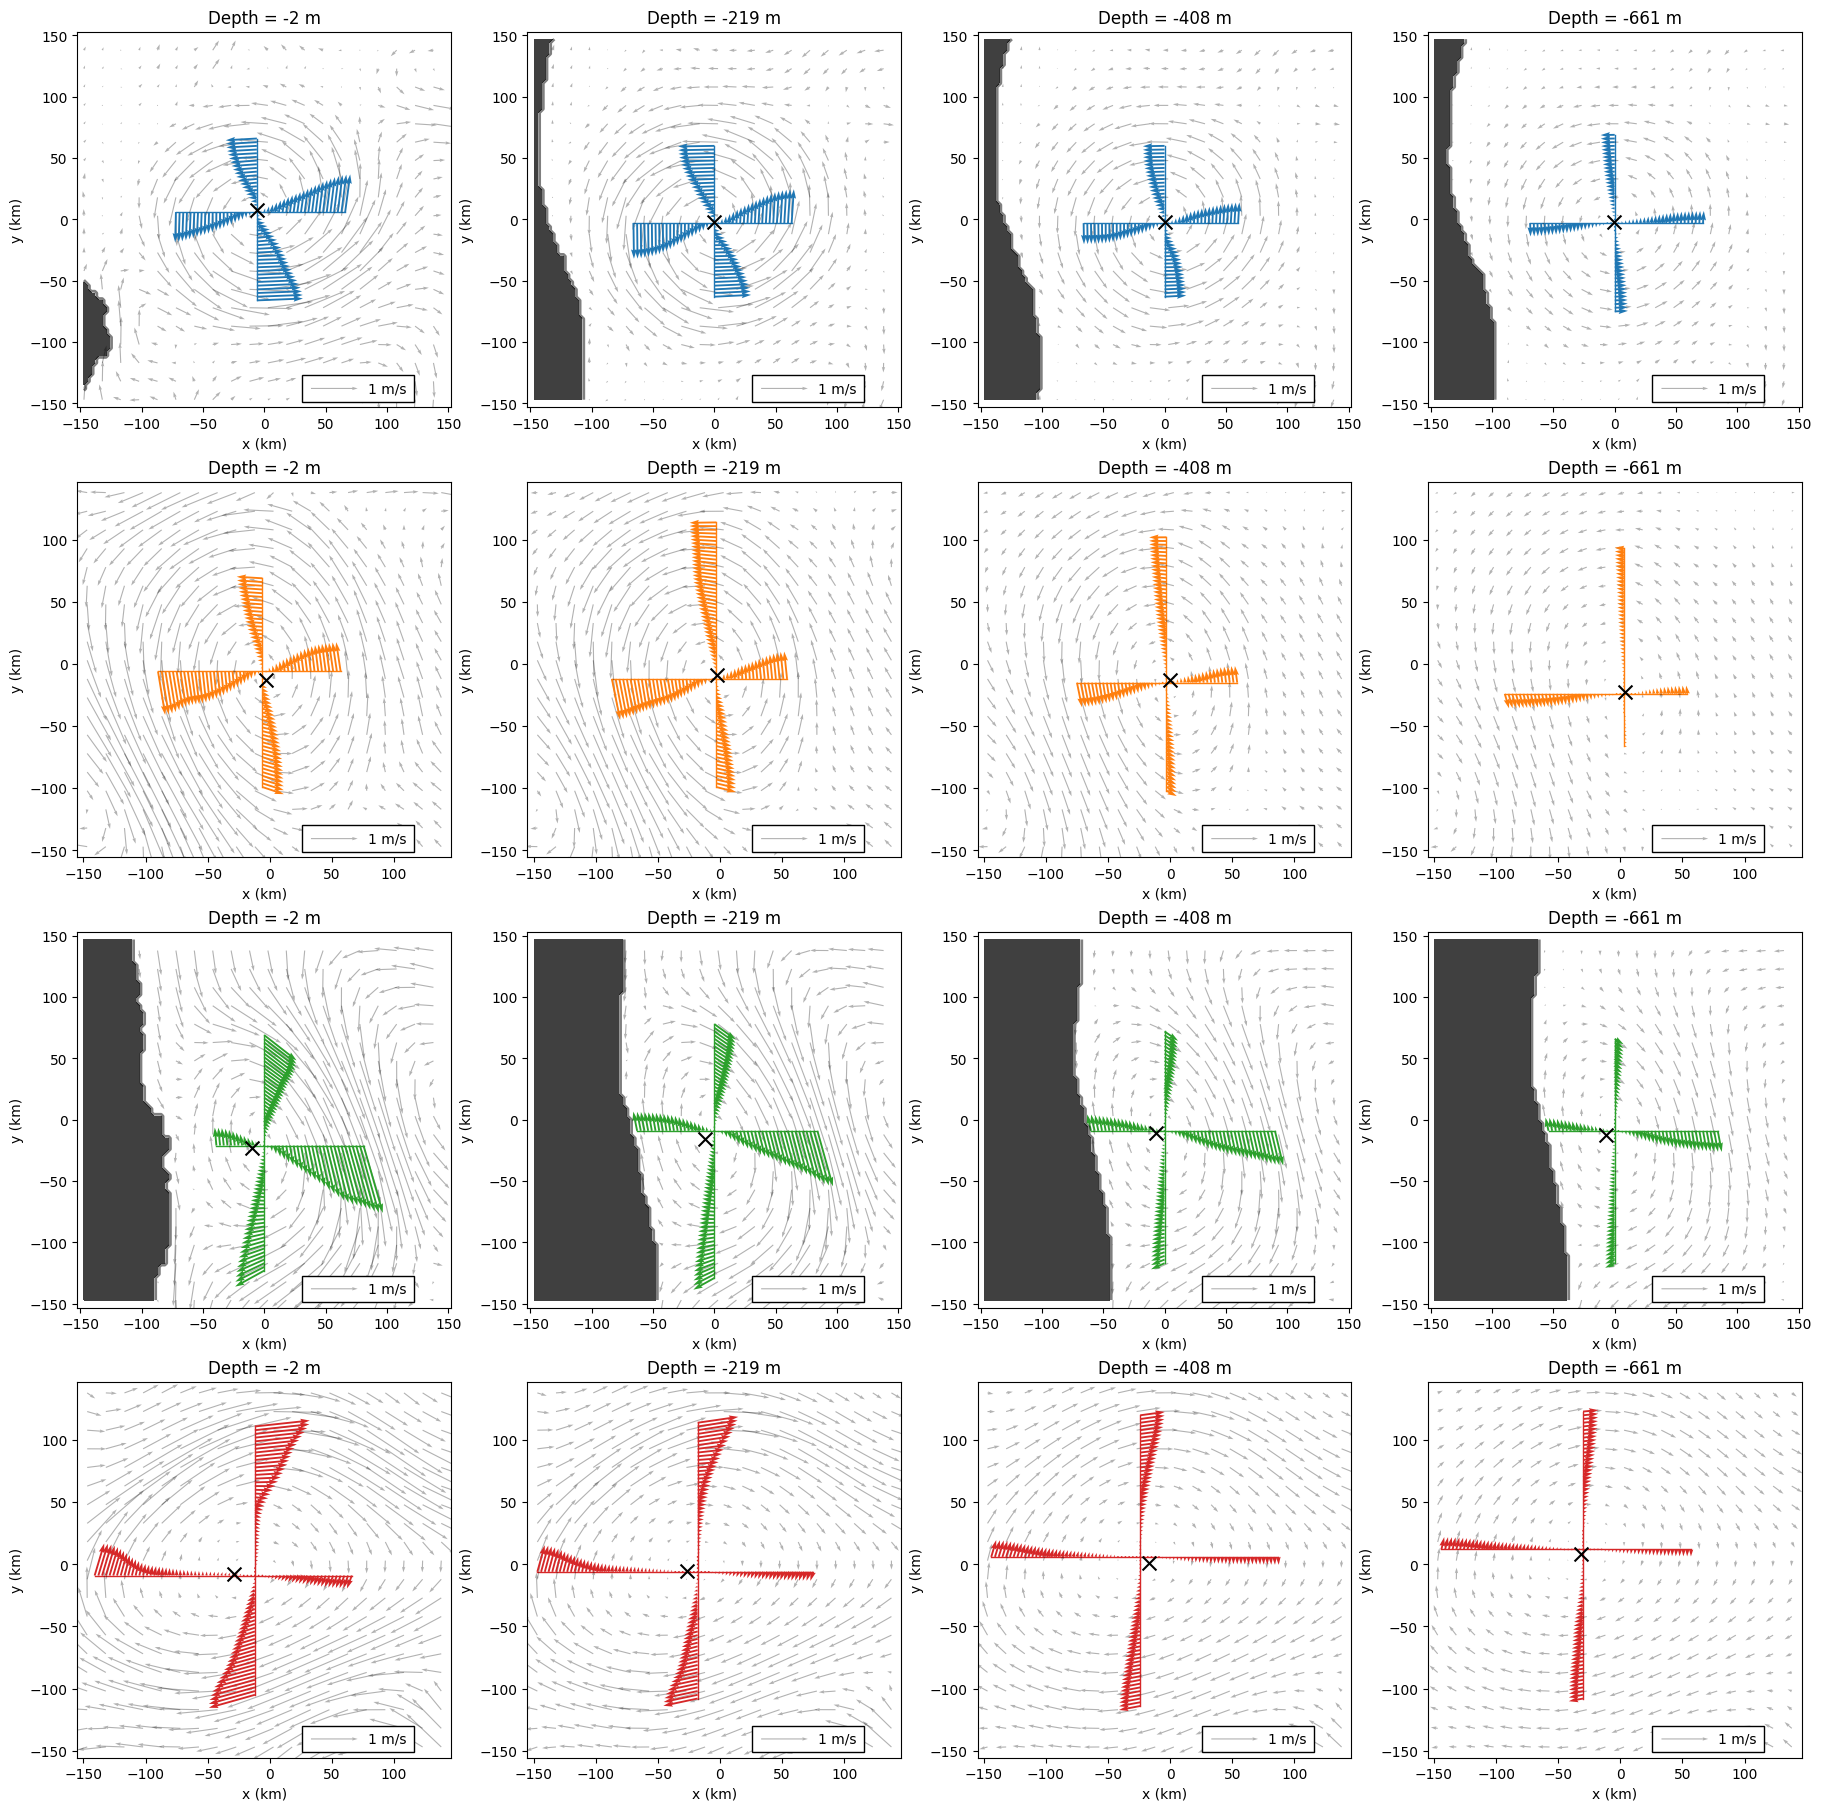

In [6]:
from matplotlib.patches import Rectangle
times = [15, 0, 15, 15]
fig, axes = plt.subplots(4, 4, figsize=(18, 18), constrained_layout=True)#, sharex=True, sharey=True)
for r, eddy in enumerate(the_frontier_eddies):
    
    t = times[r]
    depth_lvls = [0, 15, 18, 20]
    
    scale_factor = [8, 8, 8, 8]
    colors = plt.cm.tab10.colors * 3
    
    for i, depth_lvl in enumerate(depth_lvls):
        ax = axes[r, i]
        
        u = sample_data[eddy]['T' + str(t)]['U'][:, :, depth_lvl]
        v = sample_data[eddy]['T' + str(t)]['V'][:, :, depth_lvl]
        x = sample_data[eddy]['T' + str(t)]['x'] / 1000
        y = sample_data[eddy]['T' + str(t)]['y'] / 1000
        
        X, Y = np.meshgrid(x, y)
        spacing = 5
        quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                  alpha=0.3, scale=scale_factor[i])
        data = plot_data[eddy]['T'+str(t)]
        n_xc = data['Depth' + str(depth_lvl)]['n_xc'] / 1000
        n_yc = data['Depth' + str(depth_lvl)]['n_yc'] / 1000
        xc = data['Depth' + str(depth_lvl)]['xc'] / 1000
        yc = data['Depth' + str(depth_lvl)]['yc'] / 1000
        xx = data['Depth' + str(depth_lvl)]['x'] / 1000
        yy = data['Depth' + str(depth_lvl)]['y'] / 1000
        
        ix = np.where(np.isin(x, xx + n_xc))[0]
        jy = np.where(np.isin(y, yy + n_yc))[0]
        i_nenc = np.where(n_xc == x)[0]
        j_nenc = np.where(n_yc == y)[0]
        iu = u[ix, j_nenc]
        iv = v[ix, j_nenc]
        ju = u[i_nenc, jy]
        jv = v[i_nenc, jy]
        
        spacing = 1
        ax.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
                  iu[::spacing], iv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
                  ju[::spacing], jv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.plot(xx + n_xc, [n_yc] * len(xx), zorder=0, linewidth=1, color=colors[r])
        ax.plot([n_xc] * len(yy), yy + n_yc, zorder=0, linewidth=1, color=colors[r])
        ax.scatter(xc, yc, marker='x', s=100, color='k')
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(f"Depth = {round(z_r[150,150,depth_lvl])} m")

        if np.any(np.isnan(u)) and r != 1:
            nan_mask = np.isnan(u)
            mask = np.where(~np.isnan(u), np.nan, 0)
            ax.contourf(x, y, mask.T, cmap='gray', zorder=-1)
            ax.contour(x, y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

        magnitude = 1
        x_pos, y_pos = 0.75, 0.05  
        box_width = 0.3  # Adjust width as needed
        box_height = 0.07  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                     label=f'{magnitude} m/s', labelpos='E')
        ax.axis('equal')
plt.show()


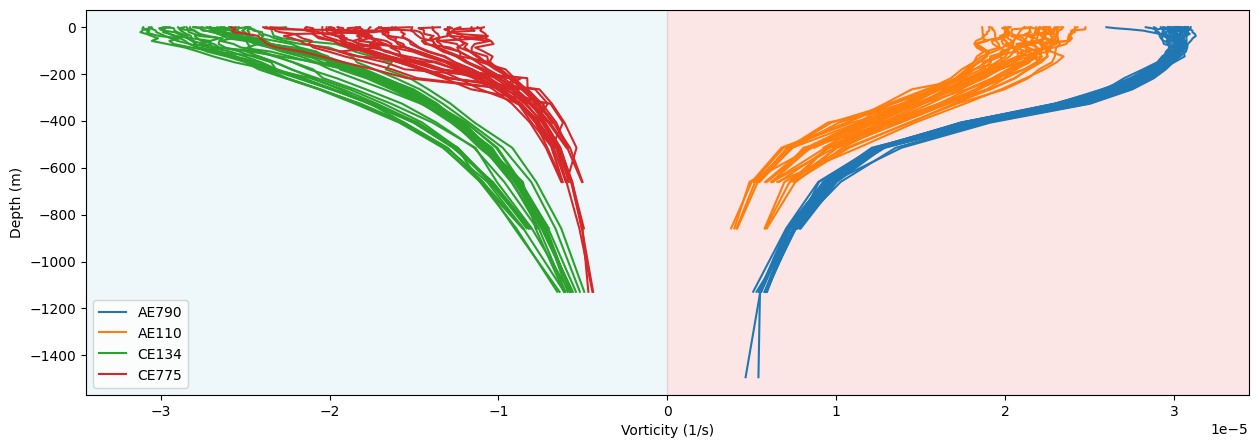

In [92]:
d_dic = {}
for eddy in the_frontier_eddies:
    d_df = pd.DataFrame()
    for t in range(30):
        df = sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]
    d_dic[eddy] = d_df

plt.figure(figsize=(15,5))
vcolors = plt.cm.tab10.colors
latex_names = ['AE790', 'AE110', 'CE134', 'CE775']
for i, eddy in enumerate(the_frontier_eddies):
    for t in range(30):
        data = plot_data[eddy]['T'+str(t)]
        vorts = []
        zcs = []
        for depth_dic in data.values():
            d_lvl = np.where(depth_dic['Depth'] == z_r[150,150,:])[0]
            if d_lvl < d_dic[eddy]['T'+str(t)][0]:
                vorts.append(depth_dic['Vort'])
                zcs.append(depth_dic['Depth'])
        if t == 0:
            label = latex_names[i]
        else:
            label = None
        plt.plot(vorts, zcs, color=vcolors[i], label=label)

current_xlims = plt.gca().get_xlim()
x1, x2 = current_xlims
xabs = max(abs(x1), abs(x2))

plt.xlim([-xabs, xabs])

plt.axvspan(-xabs, 0, color='lightblue', alpha=0.2)  
plt.axvspan(0, xabs, color='lightcoral', alpha=0.2)  

plt.xlabel('Vorticity (1/s)')
plt.ylabel('Depth (m)')
plt.legend()

In [138]:
for eddy in the_frontier_eddies:
    VG_vort_df = pd.DataFrame()
    for t in range(30):
        vorts = []
        for i, depth_dic in enumerate(plot_data[eddy]['T'+str(t)].values()):
            vorts.append(depth_dic['Vort'])
        if i != 29:
            vorts.extend([np.nan] * (29 - i))
        VG_vort_df['T'+str(t)] = vorts
    VG_vort[eddy] = VG_vort_df

# with open('/srv/scratch/z5297792/Sample/VG_vort.pkl', 'wb') as file:
#     pickle.dump(VG_vort, file)

In [140]:
method = 'COW'

x_df = pd.DataFrame()
y_df = pd.DataFrame()

eddy = the_frontier_eddies[-1]
for t in range(30):

    x_data = (sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
    y_data = (sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000

    # x_data = (sample_data[eddy][f'T{t}'][method]['x'] - sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
    # y_data = (sample_data[eddy][f'T{t}'][method]['y'] - sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)

In [141]:
x_df

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.285714,0.000000,0.428571,-2.181818,-0.696594,0.784314,4.800000,0.000000,0.583333,2.000000,...,2.000000,1.800000,0.000000,1.800000,0.900000,-6.000000,-6.600000,-0.350000,-2.000000,-1.418182
2,0.285714,-0.600000,0.428571,0.484848,-1.078947,-0.020833,4.500000,-4.500000,0.431818,1.600000,...,-4.150000,1.285714,0.000000,0.500000,-0.315789,0.000000,-4.800000,0.200000,0.545455,-2.318182
3,1.285714,0.000000,0.000000,-0.181818,-1.851675,-1.333333,3.000000,-4.000000,-1.750000,3.875000,...,-0.250000,0.857143,0.000000,1.200000,3.000000,0.500000,-4.500000,-0.412500,-1.666667,0.119318
4,1.285714,0.187500,0.000000,-0.231818,-3.453947,-1.333333,3.000000,-5.000000,-0.134615,3.875000,...,0.000000,3.000000,-0.600000,4.500000,1.363636,0.000000,-4.500000,-1.725000,-0.545455,-4.418182
5,1.285714,-0.250000,3.750000,-2.015152,-3.745614,-1.333333,-1.500000,-5.000000,1.250000,5.200000,...,-3.727273,-2.142857,-2.250000,1.333333,2.000000,-0.833333,-6.937500,-1.725000,-1.333333,-0.318182
6,1.285714,0.000000,4.500000,-3.129187,-4.078947,-1.509804,-1.500000,-6.600000,0.431818,6.500000,...,-0.400000,0.000000,-2.250000,-1.588235,2.700000,-0.600000,-8.250000,-2.800000,-5.000000,-4.636364
7,1.285714,0.000000,4.588235,-3.129187,-4.851675,-2.166667,-3.000000,-6.000000,1.250000,6.500000,...,-3.727273,-2.142857,0.000000,1.500000,3.315789,-1.312500,-8.800000,-2.800000,-1.636364,-0.484848
8,2.285714,0.000000,3.562500,-4.681818,-3.631579,-3.500000,-1.125000,-1.500000,1.850000,6.500000,...,-0.250000,0.000000,-3.315789,1.500000,6.000000,-3.600000,-10.800000,-3.412500,-2.100000,-4.151515
9,1.285714,-2.000000,3.000000,-6.000000,-3.947368,-5.383333,-3.750000,-5.181818,4.250000,6.500000,...,0.000000,-1.800000,0.000000,3.000000,3.250000,-5.647059,-10.058824,-1.600000,-1.500000,-0.518182
